Data Retrieved from: https://archive.ics.uci.edu/dataset/2/adult

As was the second Jupyter cell ( Import in Python button on that page)

# Goal and Introduction

The goal is to use this dataset to try to predict if someone makes over 50,000 dollar a year using a variety of variables such as occupation, age, education. There is a mix of categorial and integer types which provides a variety of ways to probe and analyze the data. Additionally, the sheer amount of variables also adds to the possible avenues for analysis.

Since this is a binary classification problem ( someone either makes more or less than/ equal to 50,000 dollars), there are a handful of possible alogrithms such as k-Nearest Neighbors, Logistic Regression, and Decision Trees. 

## General Outline

* Make sure the data has the correct variable types, and the values make sense
  * Make sure the missing values are rectified and that the unique values make sense
* Prod the data using some basic statistics like correlations, and some graphing
* Pick a ML model that works well for binary classification and implement it
* Discuss the Results

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xgboost as xgb

In [103]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [107]:
X.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [106]:
X['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked',
       nan], dtype=object)

In [105]:
X['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [109]:
X['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [110]:
X['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv', nan], dtype=object)

In [111]:
X['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [113]:
X['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [114]:
X['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands', nan], dtype=object)

## Step 1: Data Cleaning

There isn't that much cleaning to do. the *unique* method and *dtypes* methods told us that everything should be fine, aside from the missing values mentioned in the documentation. The page on UCI's archive does say there are missing values so those will be converted to *Numpy's* **Nan** type for the sake of compatibility. This is marginally beneficial especially since missing values were only represented by question marks. 

There is the additional problem that the targets have not 2, but 4 different variables represented. 

*workclass* will be used as the example variable to show the change in the missing values.

In [89]:
X['workclass'].value_counts()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [90]:
y.value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [91]:
X = X.replace('?', np.nan)
y = y.replace('<=50K.', '<=50K')
y = y.replace('>50K.', '>50K')

In [92]:
X['workclass'].value_counts()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [93]:
y.value_counts()

income
<=50K     37155
>50K      11687
Name: count, dtype: int64

## Step 2: Preliminary Analysis

A nice first step would be to see how each variable is distributed. This is of varying utility, but just seeing which variables are normal, which are not, and seeing the number of outliers can help decide what model to use. Oftentimes, it is valuable to see if and how data is clustered partly for figuring out which model to use but also because it can give insight into how useful certain features are for predictions.

Numerical variables will simply be displayed using a histogram but categorical variables will be displayed using the *plot* feature of *pandas* (which is just the *matplotlib* method applied to a dataframe). 

The target varaible should be converted to an integer so it can be used with the **corr** method. This will give some simple insight into how the data is connected, though it should be noted that it gives no insight into categorical variables like *occupation*.

After this, it will be time to pick a model and implement it.

In [94]:
X['marital-status'].value_counts()

marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

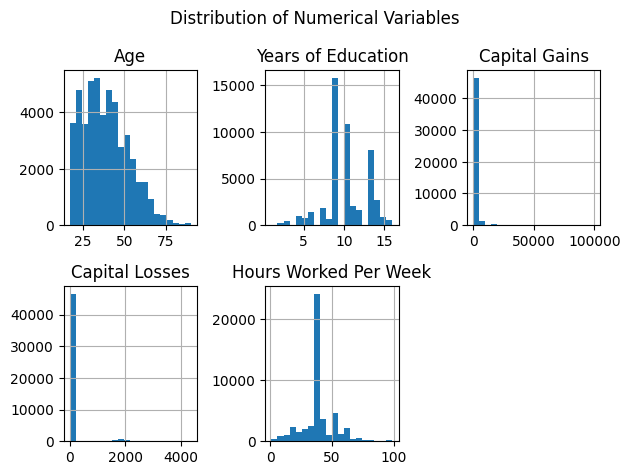

In [95]:
fig, ax = plt.subplots(2,3)
X['age'].hist(bins=20,ax=ax[0,0])
ax[0,0].set_title('Age')
X["education-num"].hist(bins=20,ax=ax[0,1])
ax[0,1].set_title("Years of Education")
X['capital-gain'].hist(bins=20,ax=ax[0,2])
ax[0,2].set_title("Capital Gains")
X['capital-loss'].hist(bins=20,ax=ax[1,0])
ax[1,0].set_title("Capital Losses")
X['hours-per-week'].hist(bins=20,ax=ax[1,1])
ax[1,1].set_title("Hours Worked Per Week")
fig.delaxes(ax[1,2])
plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()

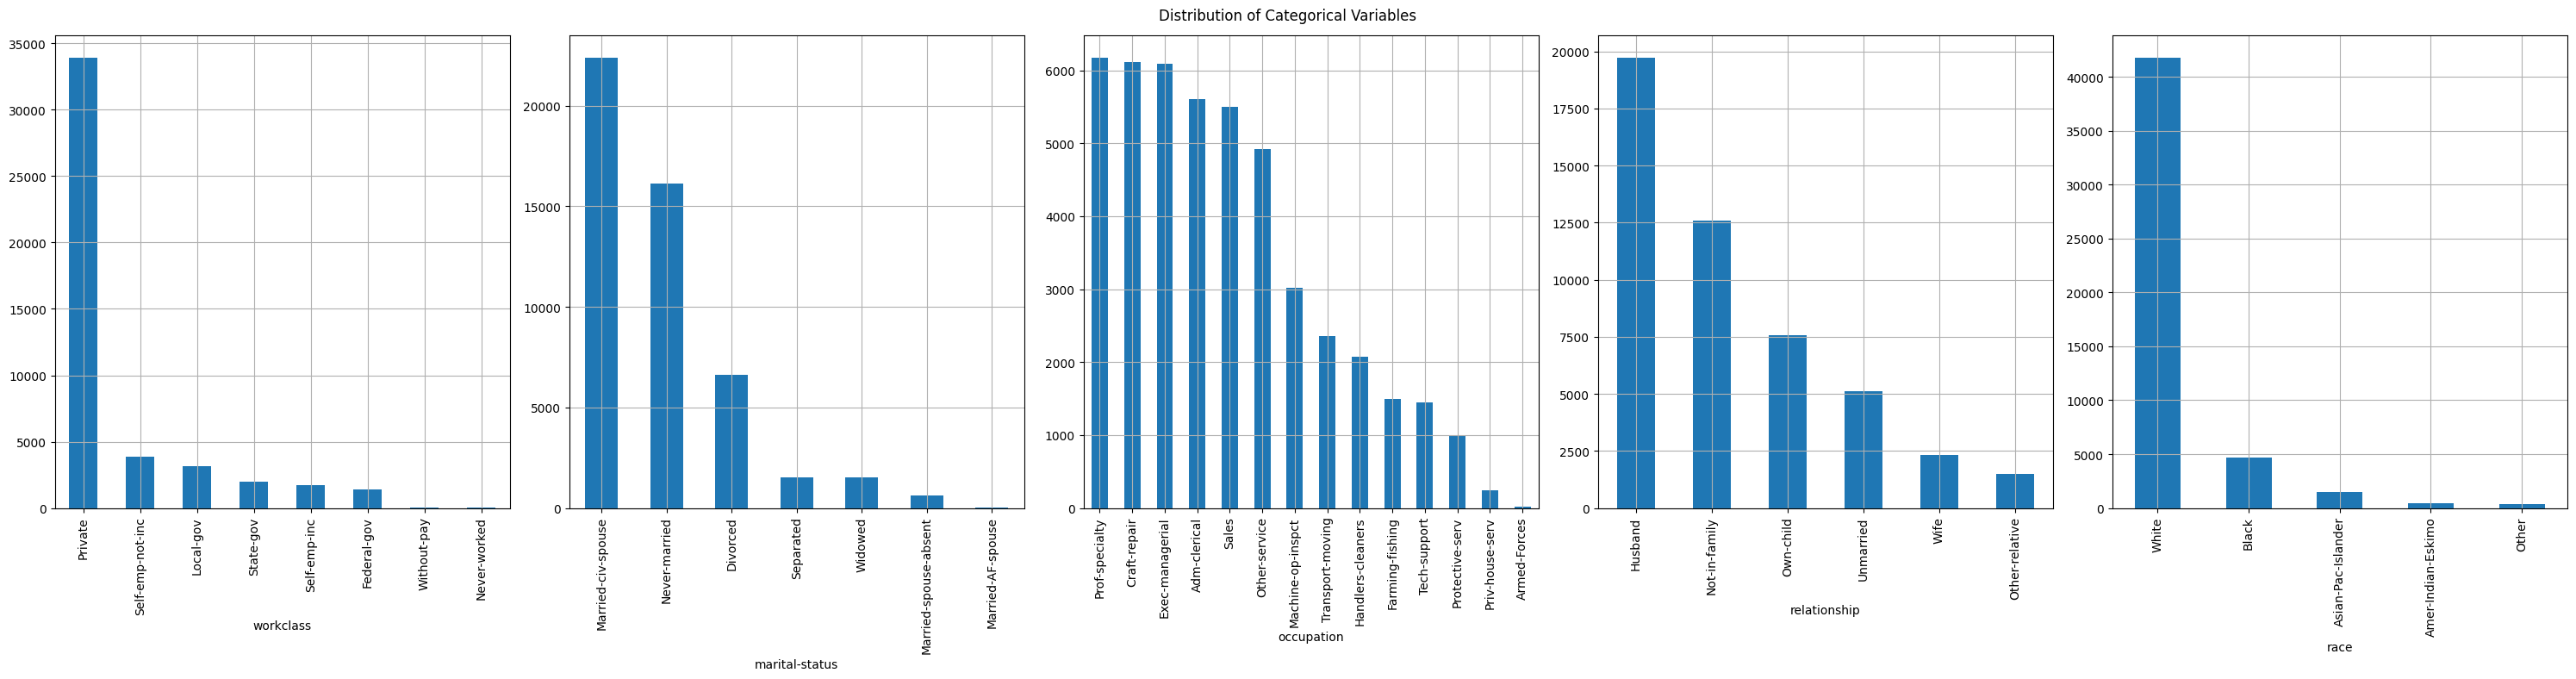

In [96]:
fig, ax = plt.subplots(1,5)
X['workclass'].value_counts().plot(kind='bar', ax=ax[0],grid=True, figsize=(30,8))
X['marital-status'].value_counts().plot(kind='bar', ax=ax[1],grid=True)
X['occupation'].value_counts().plot(kind='bar', ax=ax[2],grid=True)
X['relationship'].value_counts().plot(kind='bar', ax=ax[3],grid=True)
X['race'].value_counts().plot(kind='bar', ax=ax[4],grid=True)
plt.suptitle('Distribution of Categorical Variables')
plt.tight_layout()

In [97]:
X['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador      

In [98]:
yInt = y.replace('<=50K', 0)
yInt = yInt.replace('>50K', 1)
JointInt = X.join(yInt)
JointInt.corr(numeric_only=True)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,0.230369
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,-0.006339
education-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,0.332613
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,0.223013
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.147554
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.227687
income,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,1.000000


## Notes on the Analysis

The distributions are not normal, but there are some trends amongst the data. Many of the variables have a distribution that is biased towards one side. For example,*age* is clustered around the 20 to 50 years old range. Otherwise the numerical variables have a few modes that data clusters around. For example, education has three modes:at around 8,10, and 12, but maybe have one value that is incredibly prevalent and the other values are uncommon. For example, *native country* has a mode of the United States and every other country is much less common.*Relationship* and *occupation* is a bit more of a gradual descent from the most popular to the least popular. 

What this shows us is that some clusters do exist, and outliers do occur. *Capital Gains* and *Capital Losses* are effectively all 0 except for a few far away from 0, for example. Certain models that are susceptible to outliers, such as Random Forest, may not work well. Additionally, since there is a large quantitity of data, there is a good argument to be made to use A tree-based model like the aforementioned Random Forest, over linear regression. 

With this in mind, *XGBoost* is a good model to use. It work well on dense datasets (Capital Gains and Losses are sparse but it should be fine), and is generally fine with outliers. This is also a good option since the UCI page lists it as the most precise and second most accurate model for this particular dataset. Other potential options like Random Forest and Support Vector are also accurate and precise and are in the same sort of bucket as xgboost. 